<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [18]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

import math

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [19]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [20]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [28]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


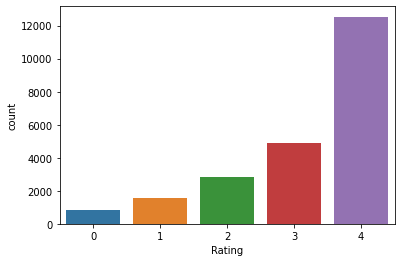

Cantidad de datos por categoría:


4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

In [29]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecto a cada clase

sns.countplot(x='Rating', data=df_reviews)
plt.show()
print("Cantidad de datos por categoría:")
df_reviews['Rating'].value_counts()

In [30]:
# Debido al desbalance que existe entre los datos, agrupo las categorias 0/1 como "malas", y 2/3 como "neutras"
df_reviews['Rating'] = df_reviews['Rating'].apply(lambda x: x//2)

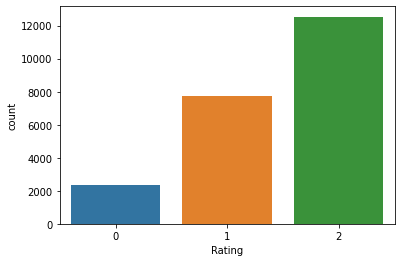

Cantidad de datos por categoría:


2    12540
1     7731
0     2370
Name: Rating, dtype: int64

In [31]:
sns.countplot(x='Rating', data=df_reviews)
plt.show()
print("Cantidad de datos por categoría:")
df_reviews['Rating'].value_counts()

In [32]:
# Agrego ejemplos extras a la clase minoritaria (oversampling)
# Aumento la cantidad de datos en aprox un 30%

from sklearn.utils import resample
from sklearn.utils import shuffle


df_upsampled = resample(df_reviews[df_reviews['Rating']==0], replace = True, 
                            n_samples = int((df_reviews['Rating']==0).sum()*.3)) 

df_reviews = pd.concat([df_reviews, df_upsampled]) 
df_reviews = shuffle(df_reviews)

In [33]:
# Elimino algunos datos de la clase mayoritaria (undersample)
# Aumento la cantidad de datos en aprox un 20%

# Porcentaje de datos a mantener
perc_to_keep = int( (df_reviews['Rating']==2).sum() * .8)

# Selecciono indices randoms que se conservaran
major_indices = df_reviews[df_reviews['Rating'] == 2].index
random_indices = np.random.choice(major_indices, perc_to_keep, replace=False)
sub_sample = df_reviews.loc[random_indices]

print("Se removeran "+str((df_reviews['Rating']==2).sum()-len(sub_sample))+" filas de la categoria 3")

# Elimino todos los datos que tienen Rating = 2
df_reviews = df_reviews[df_reviews['Rating']!=2]
df_reviews = pd.concat([df_reviews, sub_sample])
df_reviews = shuffle(df_reviews)

Se removeran 2508 filas de la categoria 3


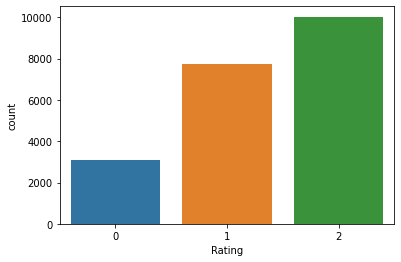

Cantidad de datos por categoría:


2    10032
1     7731
0     3081
Name: Rating, dtype: int64

In [34]:
sns.countplot(x='Rating', data=df_reviews)
plt.show()
print("Cantidad de datos por categoría:")
df_reviews['Rating'].value_counts()

In [35]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews. ¿Cuántas reviews (rows) hay para evaluar?
text_sequences = df_reviews['Review Text'].values
len(text_sequences)

20844

In [36]:
# Alumno: Concatenar todas las reviews para armar el corpus. ¿Cuál es la longitud de ese corpus?
corpus = ' '.join(text_sequences)
len(corpus)

6479224

In [37]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [38]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['i',
 'love',
 'this',
 'dress',
 'it',
 'is',
 'loose',
 'fitting',
 'so',
 'be',
 'prepared',
 'for',
 'that',
 'i',
 'ordered',
 'an',
 'xs',
 'i',
 'believe',
 'the']

In [39]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1268098

In [40]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [41]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14197

In [42]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)
sequences[0]

[2,
 22,
 7,
 18,
 4,
 6,
 176,
 352,
 16,
 29,
 12,
 20,
 2,
 51,
 58,
 100,
 2,
 863,
 1,
 18,
 14,
 8,
 27,
 7,
 106,
 156,
 3,
 2,
 138,
 19,
 101,
 4,
 74,
 34,
 116,
 11,
 30,
 2,
 431,
 33,
 5,
 427,
 39,
 1083,
 9,
 246,
 7,
 40,
 29,
 5,
 36,
 18,
 8,
 33,
 48,
 41,
 120,
 1503,
 11,
 5,
 116,
 2,
 234,
 356,
 8,
 33,
 7,
 18,
 9,
 1,
 144,
 3,
 863,
 2,
 54,
 33,
 4,
 665,
 4,
 89,
 52,
 13,
 5,
 1398,
 49,
 8,
 4,
 2,
 138,
 101,
 4,
 113,
 29,
 193,
 15,
 524,
 156,
 2,
 54,
 279,
 33,
 4,
 15,
 541]

In [43]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

115

In [44]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras.preprocessing.sequence import pad_sequences
maxlen = 115

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [45]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(20844, 115)

In [46]:
a = np.array(df_reviews['Rating'].values)
np.unique(a)

array([0, 1, 2])

In [47]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 3)
from keras.utils.np_utils import to_categorical

y_np_array = np.array(df_reviews['Rating'].values)
print("Datos únicos: "+str(np.unique(y_np_array)))
y = to_categorical(y_np_array)
print("Shape de y: "+str(y.shape))
print(y[:5])

Datos únicos: [0 1 2]
Shape de y: (20844, 3)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [48]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y) # Para conservar la distribucion de los datos

In [49]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 3               # multi-class classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 3


### 2 - Entrenar el modelo con Embeddings + LSTM

In [50]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 50)           100050    
                                                                 
 lstm (LSTM)                 (None, 115, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 115, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8

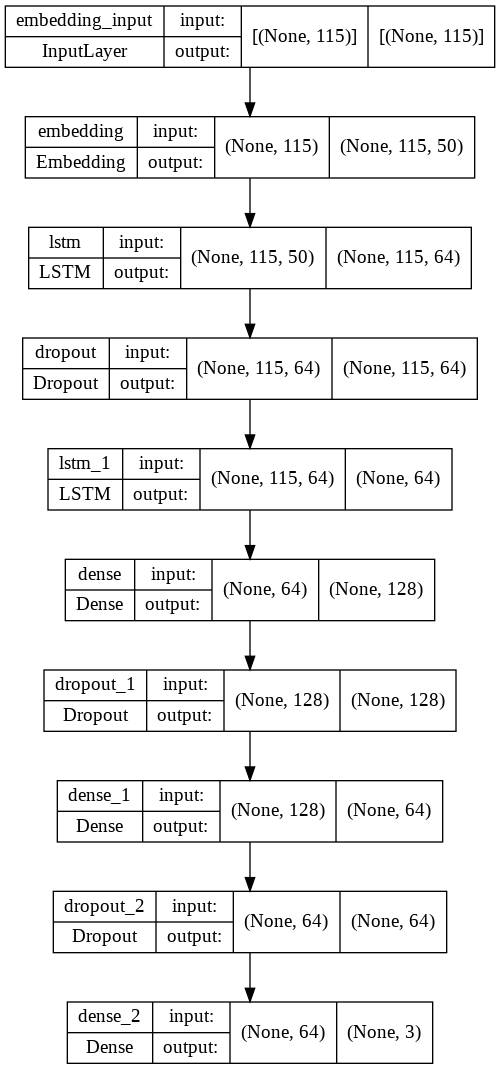

In [51]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [53]:
hist = model.fit(X_train, y_train, epochs=7, validation_split=0.2)

Epoch 1/7
417/417 [==============================] - 25s 61ms/step - loss: 0.3401 - accuracy: 0.8661 - val_loss: 0.9541 - val_accuracy: 0.6522
Epoch 2/7
417/417 [==============================] - 24s 58ms/step - loss: 0.2978 - accuracy: 0.8874 - val_loss: 1.1141 - val_accuracy: 0.6534
Epoch 3/7
417/417 [==============================] - 24s 58ms/step - loss: 0.2767 - accuracy: 0.8970 - val_loss: 1.1935 - val_accuracy: 0.6570
Epoch 4/7
417/417 [==============================] - 24s 58ms/step - loss: 0.2428 - accuracy: 0.9130 - val_loss: 1.3098 - val_accuracy: 0.6306
Epoch 5/7
417/417 [==============================] - 24s 58ms/step - loss: 0.2358 - accuracy: 0.9147 - val_loss: 1.2051 - val_accuracy: 0.6474
Epoch 6/7
417/417 [==============================] - 24s 58ms/step - loss: 0.2336 - accuracy: 0.9151 - val_loss: 1.3657 - val_accuracy: 0.6351
Epoch 7/7
417/417 [==============================] - 24s 58ms/step - loss: 0.1866 - accuracy: 0.9333 - val_loss: 1.5173 - val_accuracy: 0.6513

In [54]:
# Guardarlo en un archivo pickle
import pickle, time
file_name = "desafio5_predict_model" + str(time.time()).split(".")[0] + ".pickle"
with open(file_name, 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://b48c45e3-a5a3-41ed-85c9-fd114333f3a1/assets


INFO:tensorflow:Assets written to: ram://b48c45e3-a5a3-41ed-85c9-fd114333f3a1/assets


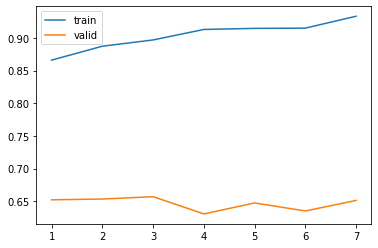

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [56]:
model.evaluate(X_test, y_test)

131/131 [==============================] - 3s 21ms/step - loss: 1.4330 - accuracy: 0.6596


[1.4330142736434937, 0.6596305966377258]